In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from keras import backend as K
img_dim_ordering = 'tf'
K.set_image_dim_ordering(img_dim_ordering)

import numpy as np

In [ ]:
from scipy.ndimage.measurements import label

In [ ]:
from util import *

In [ ]:
data_dir = 'data'

In [ ]:
X_train_imgs_filename = '%s/X_train_imgs.csv' % data_dir
X_val_imgs_filename = '%s/X_val_imgs.csv' % data_dir
X_test_imgs_filename = '%s/X_test_imgs.csv' % data_dir
y_train_filename = '%s/y_train.csv' % data_dir
y_val_filename = '%s/y_val.csv' % data_dir
y_test_filename = '%s/y_test.csv' % data_dir

In [ ]:
X_train_img_files = read_img_file_csv(X_train_imgs_filename)
X_val_img_files = read_img_file_csv(X_val_imgs_filename)
X_test_img_files = read_img_file_csv(X_test_imgs_filename)
y_train = read_label_file_csv(y_train_filename)
y_val = read_label_file_csv(y_val_filename)
y_test = read_label_file_csv(y_test_filename)

In [ ]:
def pretrained_model(img_shape, num_classes, activation='relu', n=4096, lr=0.001):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    for layer in model_vgg16_conv.layers:
        layer.trainable = False
        
    #model_vgg16_conv.summary()
    
    #Create your own input format
    keras_input = Input(shape=img_shape, name = 'image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(keras_input)
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(n, activation=activation, name='fc1')(x)
    x = Dense(n, activation=activation, name='fc2')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    optimizer = Adam(lr=lr)
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                             metrics=['accuracy'])
    
    return pretrained_model

In [ ]:
X_train_imgs = read_imgs(X_train_img_files, scale_to_255=True)
X_train_imgs.shape

In [ ]:
X_train_img_files[:5]

In [ ]:
def vgg_load_imgs(X_img_files):
    X_img_arr = []
    for img_path in tqdm(X_img_files):
        #print(img_path)
        curr_img = image.load_img(img_path, target_size=(64, 64))
        X_img_arr.append(curr_img.copy())
        curr_img.close()

    X_imgs = np.stack(X_img_arr)    
    
    return X_imgs.astype(np.float32)/255.0

In [ ]:
X_train_img_files, y_train = shuffle_train_data(X_train_img_files, y_train)

cutoff = int(0.1*len(y_train))
_X_train_img_files = X_train_img_files[:cutoff]
_y_train = y_train[:cutoff]

_X_train = vgg_load_imgs(_X_train_img_files)
_X_train.shape

In [ ]:
X_train = vgg_load_imgs(X_train_img_files)
X_train.shape

In [ ]:
X_train[0].min(), X_train[0].max()

In [ ]:
display_images(X_train, start_idx=0, end_idx=10)

In [ ]:
X_val = vgg_load_imgs(X_val_img_files)
X_val.shape

In [ ]:
X_test = vgg_load_imgs(X_test_img_files)
X_test.shape

# Model

In [ ]:
model_file = '%s/model.h5' % data_dir

In [ ]:
model = pretrained_model((64, 64, 3), 2, n=512, lr=0.0001)

In [ ]:
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=2,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks = [checkpoint]        

In [ ]:
model.fit(x=X_train, y=np.array(y_train), batch_size=32, epochs=20, verbose=2, callbacks=callbacks, 
          validation_data=(X_val, np.array(y_val)), shuffle=True, initial_epoch=0)

In [ ]:
model = load_model(model_file)

In [ ]:
model.evaluate(X_test, np.array(y_test))

In [ ]:
model.predict(X_test[10:20])

In [ ]:
display_images(X_test[10:20])

# Search

In [ ]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, model):    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    test_imgs = np.array([cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
                          for window in windows])
    
    predictions = model.predict(test_imgs)
    for i in range(predictions.shape[0]):
        prediction = predictions[i][1]
        #print(prediction)
        
        if prediction > 0.5:
            on_windows.append(windows[i])
            
    #8) Return windows for positive detections
    return on_windows

In [ ]:
#image = read_img('test_images/test1.jpg', scale_to_255=False)

In [ ]:
img = np.asarray(image.load_img('test_images/test1.jpg')).astype(np.float32)/255.0
plt.imshow(img)
plt.show()

In [ ]:
img.min(), img.max()

In [ ]:
y_start_stop = [300, None]

In [ ]:
draw_img = np.copy(img)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(img, windows, model)

window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 1.0), thick=6)                    

plt.imshow(window_img)
plt.show()

In [ ]:
img.shape

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1.0), 6)
    # Return the image
    return img

In [ ]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)

In [ ]:
# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
print(heat.min(), heat.max())

plt.imshow(heat, cmap='gray')
plt.show()

# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.figure(figsize=(32, 32))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.tight_layout()
plt.show()

In [ ]:
def get_labeled_img_with_heatmap(img, model, x_start_stop=[None, None], y_start_stop=[400, None], 
                                 xy_window_arr=[(64, 64), (128, 128)], xy_overlap=(0.5, 0.5),
                                 heat_threshold=0, hot_windows_arr=[], max_hot_windows=5):    
    windows = []
    for xy_window in xy_window_arr:
        windows += slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                                xy_window=xy_window, xy_overlap=xy_overlap)
    #print(windows)

    hot_windows = search_windows(img, windows, model)
    
    hot_windows_arr.append(hot_windows)
    if len(hot_windows_arr) > max_hot_windows:
        hot_windows_arr = hot_windows_arr[-max_hot_windows:]
        
    hot_windows = []
    for curr_hot_windows in hot_windows_arr:
        hot_windows += curr_hot_windows
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 1.0).astype(np.uint8)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap, hot_windows_arr

In [ ]:
draw_img, heat_map, hot_windows_arr = get_labeled_img_with_heatmap(img, model, 
                                                                   x_start_stop=[None, None], 
                                                                   y_start_stop=[400, None], 
                                                                   xy_window_arr=[(64, 64),(128,128)], xy_overlap=(0.5, 0.5), 
                                                                   heat_threshold=0, max_hot_windows=5)

In [ ]:
plt.figure(figsize=(32, 32))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.tight_layout()
plt.show()

In [ ]:
output_dir = 'output_images' 

In [ ]:
project_img_files = sorted(glob.glob('%s/*.jpg' % output_dir))
sample_project_imgs = read_imgs(project_img_files[:10], scale_to_255=False)
sample_project_imgs[0].min(), sample_project_imgs.max()

In [59]:
128+32

160

In [ ]:
#draw_img_arr = []
#heat_map_arr = []
hot_windows_arr = []

for img_file in tqdm(project_img_files):
#for i in tqdm(range(174,194)):
    img_file = project_img_files[i]
    img = read_img(img_file, scale_to_255=False).astype(np.float32)/255.0
    
    draw_img, heat_map, hot_windows_arr = get_labeled_img_with_heatmap(img, model, 
                                                                       x_start_stop=[None, None], 
                                                                       y_start_stop=[400, None], 
                                                                       xy_window_arr=[
                                                                           (32,32),(64, 64),
                                                                           (96,96), (128,128),
                                                                           (160,160)], 
                                                                       xy_overlap=(0.5, 0.5),
                                                                       hot_windows_arr=hot_windows_arr, 
                                                                       max_hot_windows=10, heat_threshold=1)
    
    #draw_img_arr.append(draw_img)
    #heat_map_arr.append(heat_map)
    #print(i, hot_windows_arr)

  8%|██████▎                                                                         | 99/1248 [01:37<18:49,  1.02it/s]

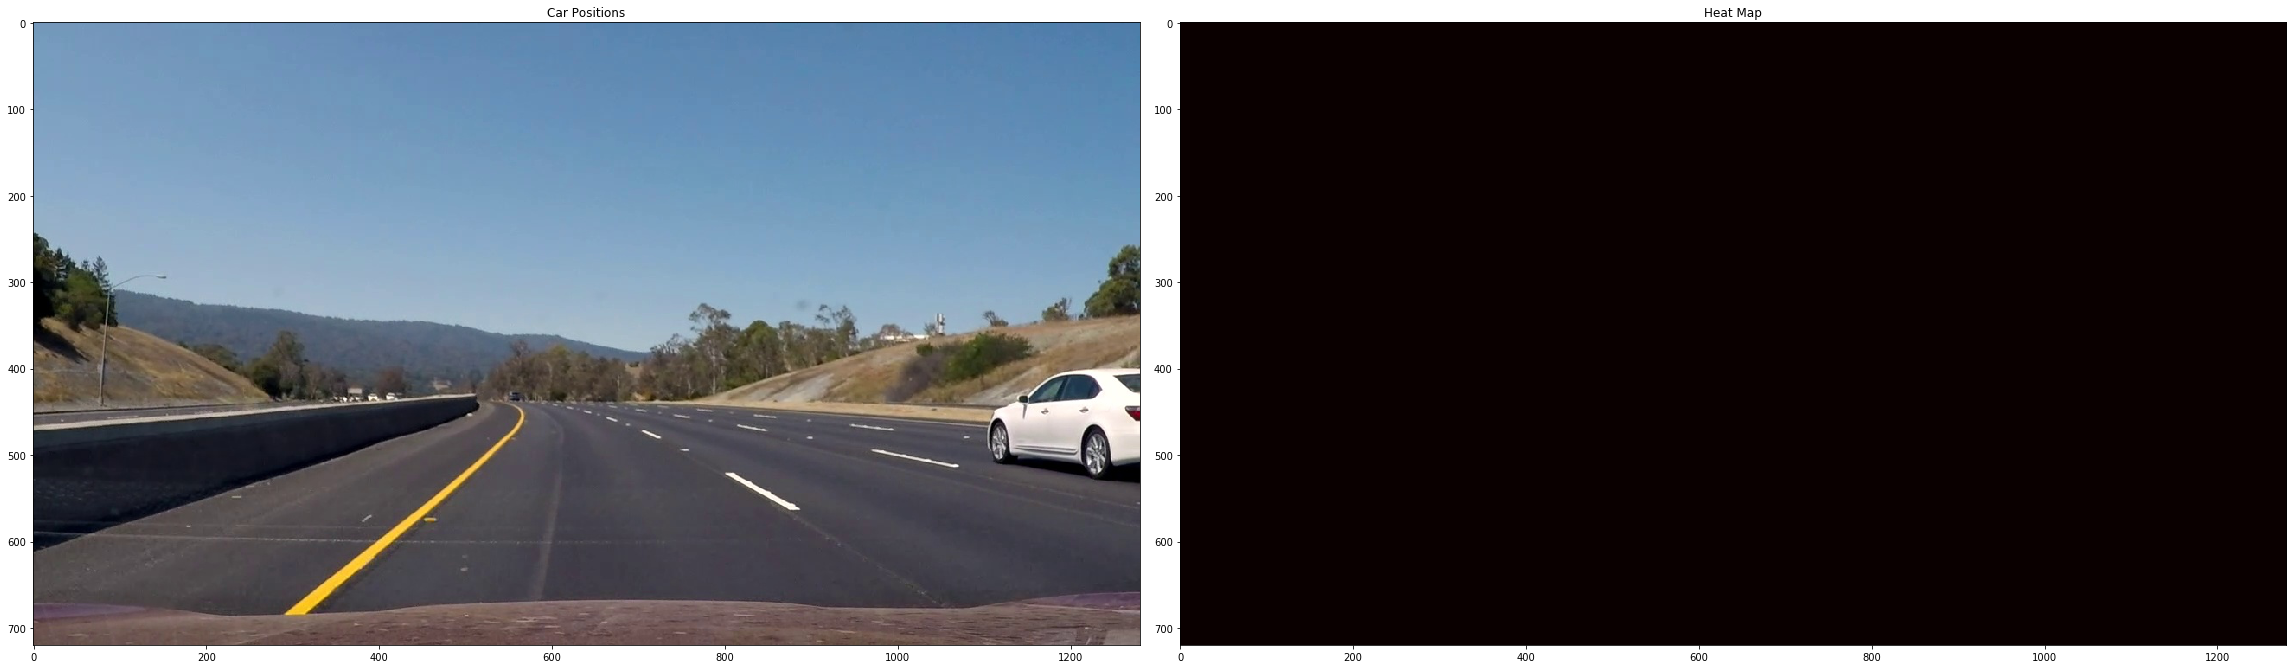

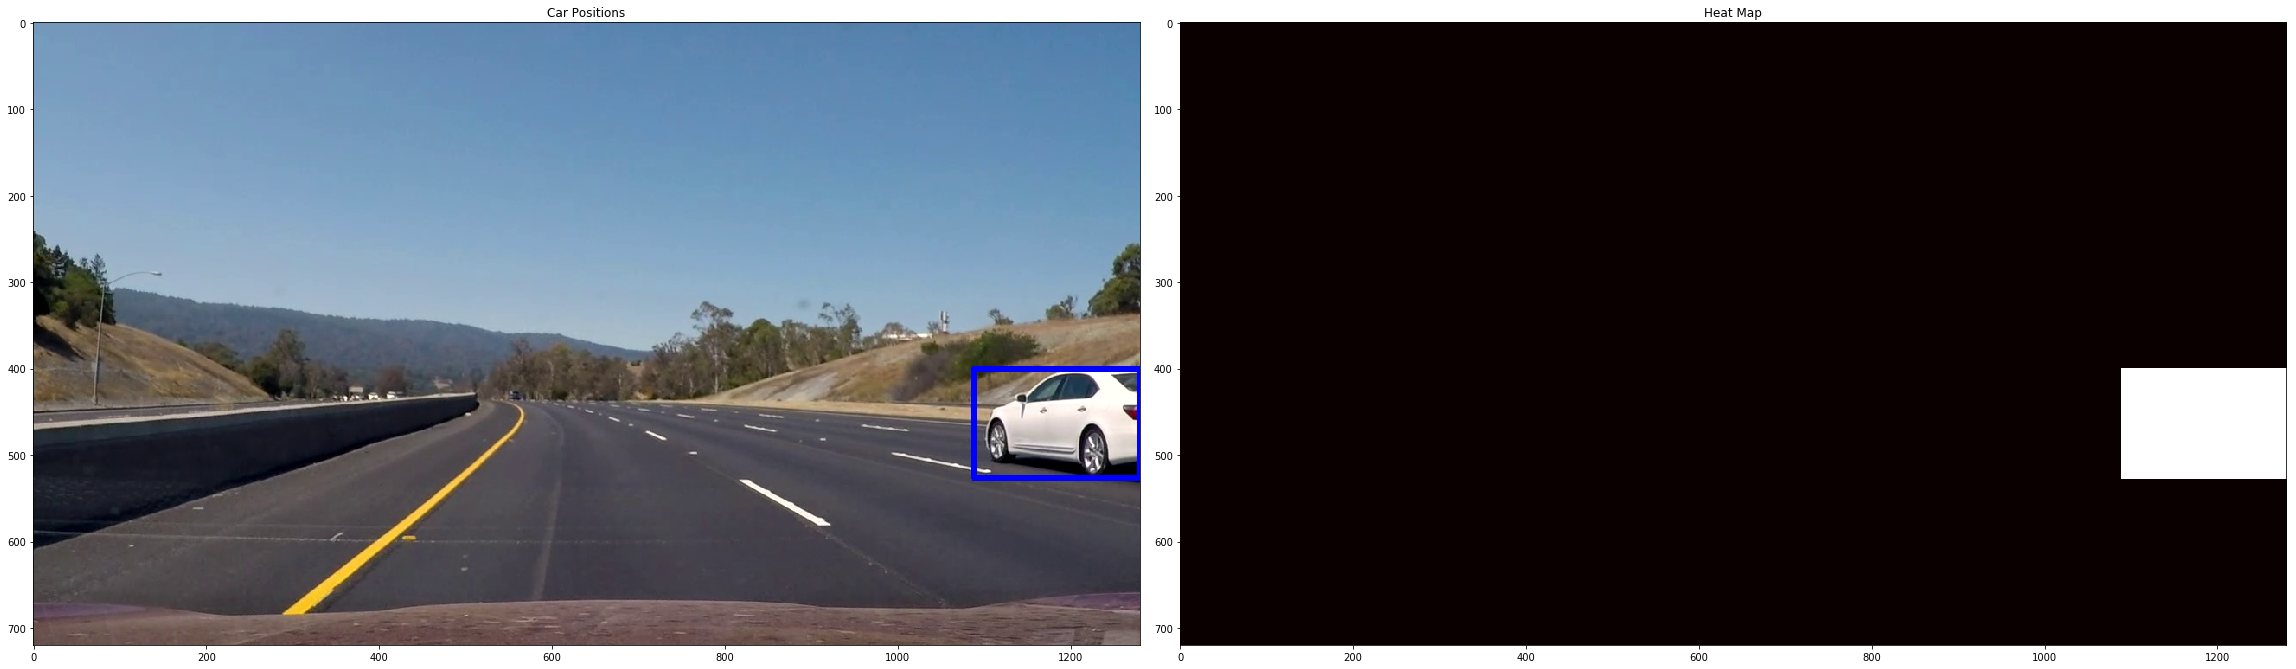

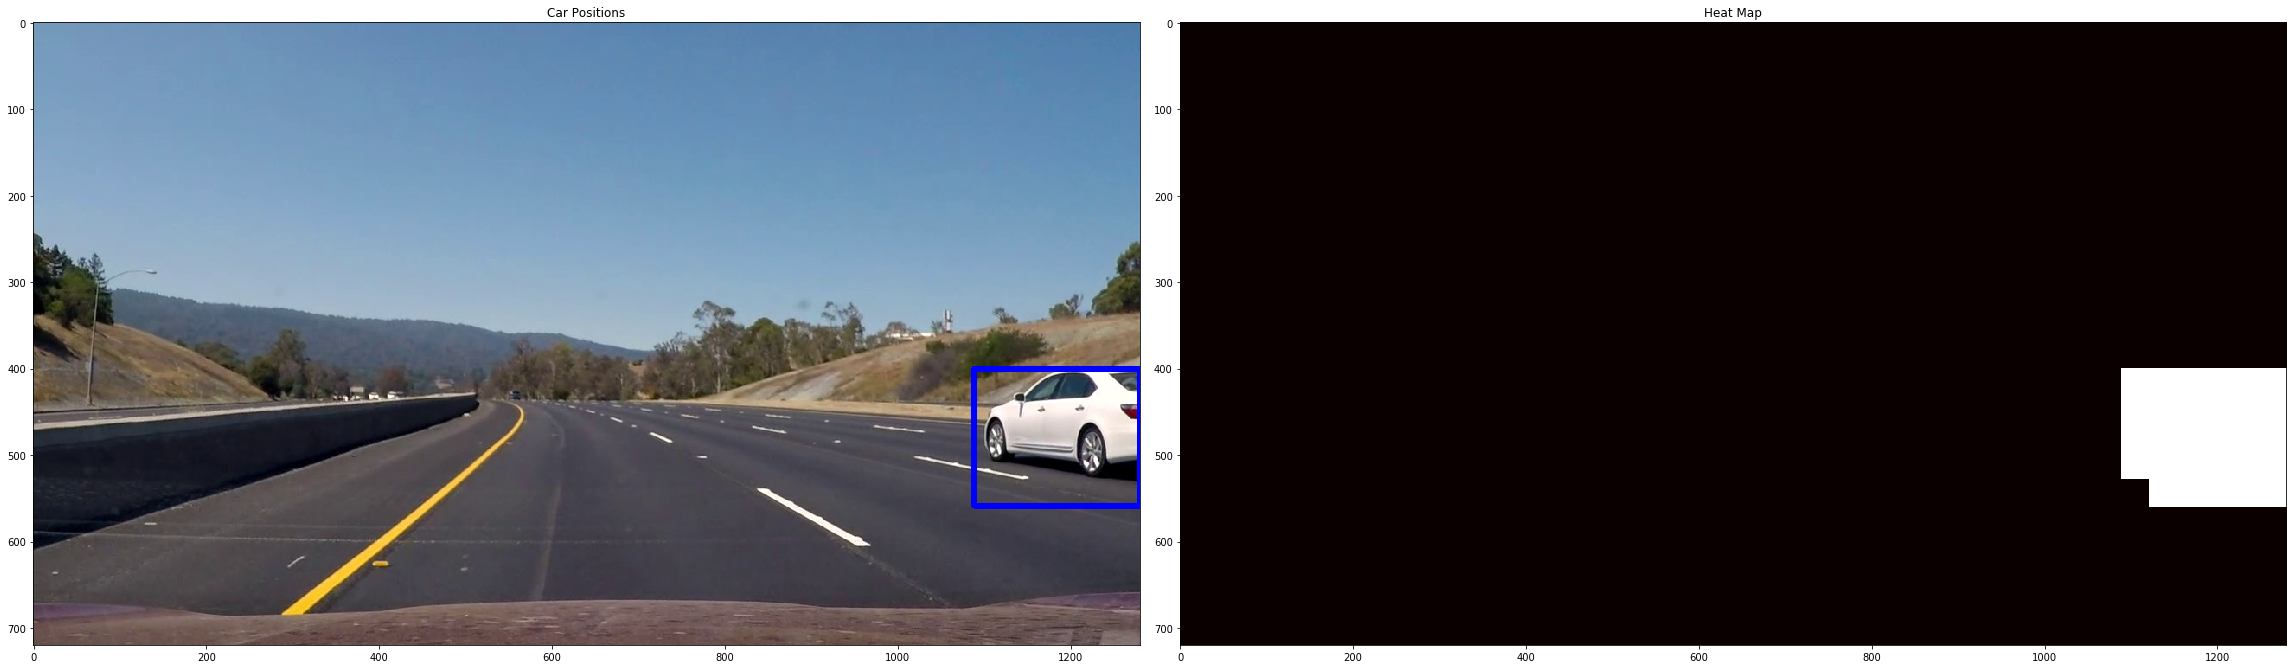

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


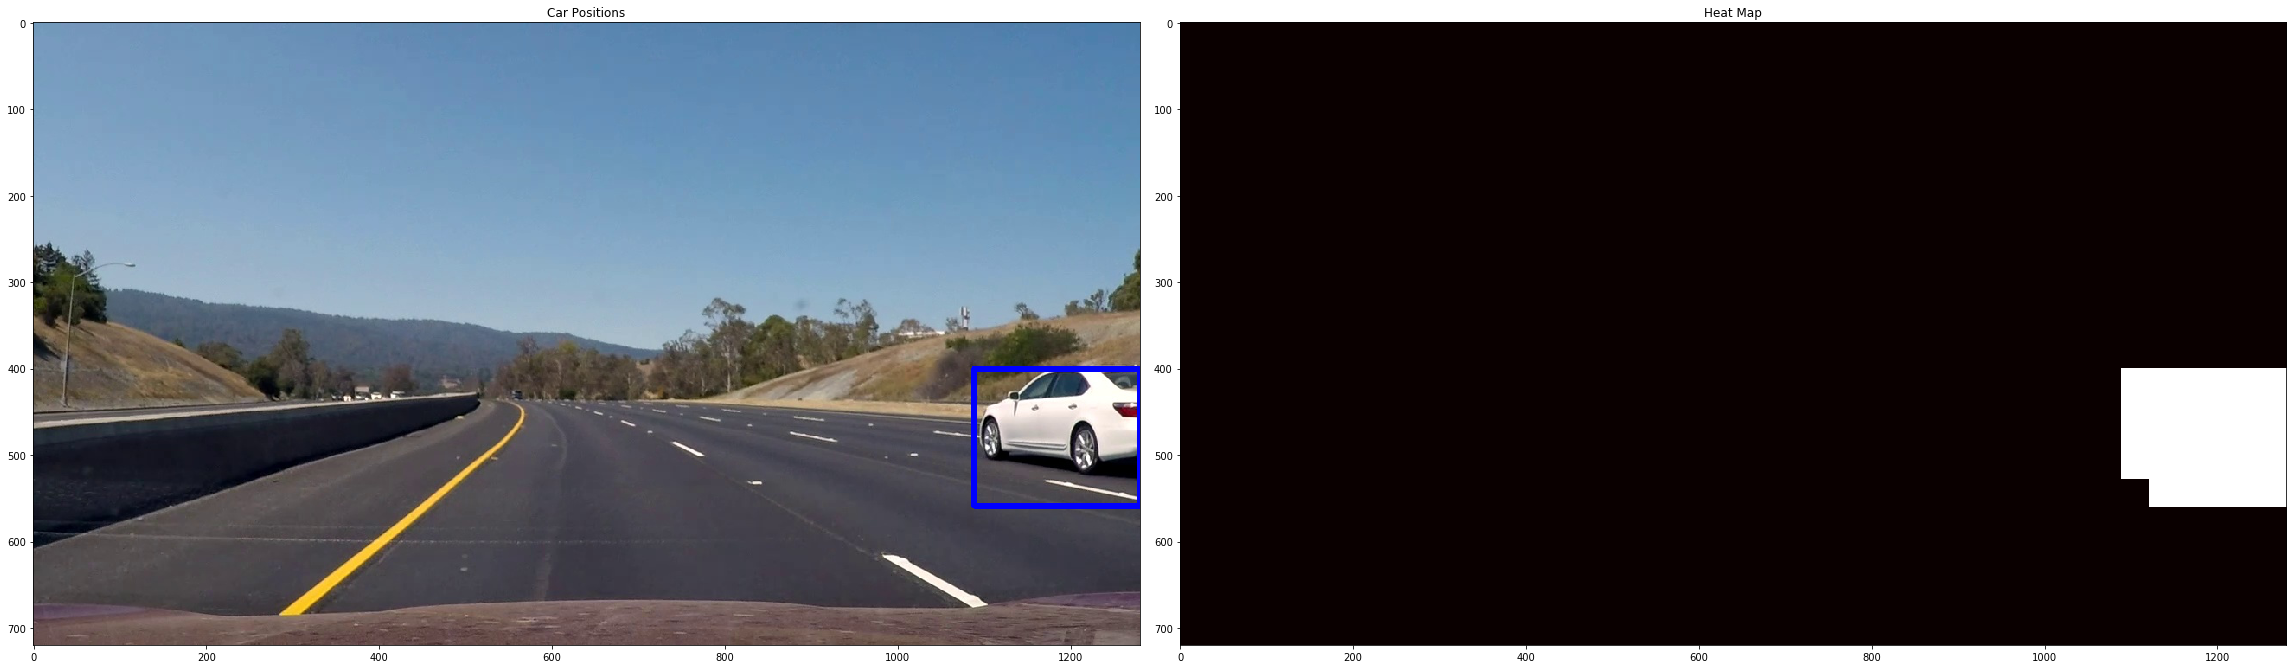

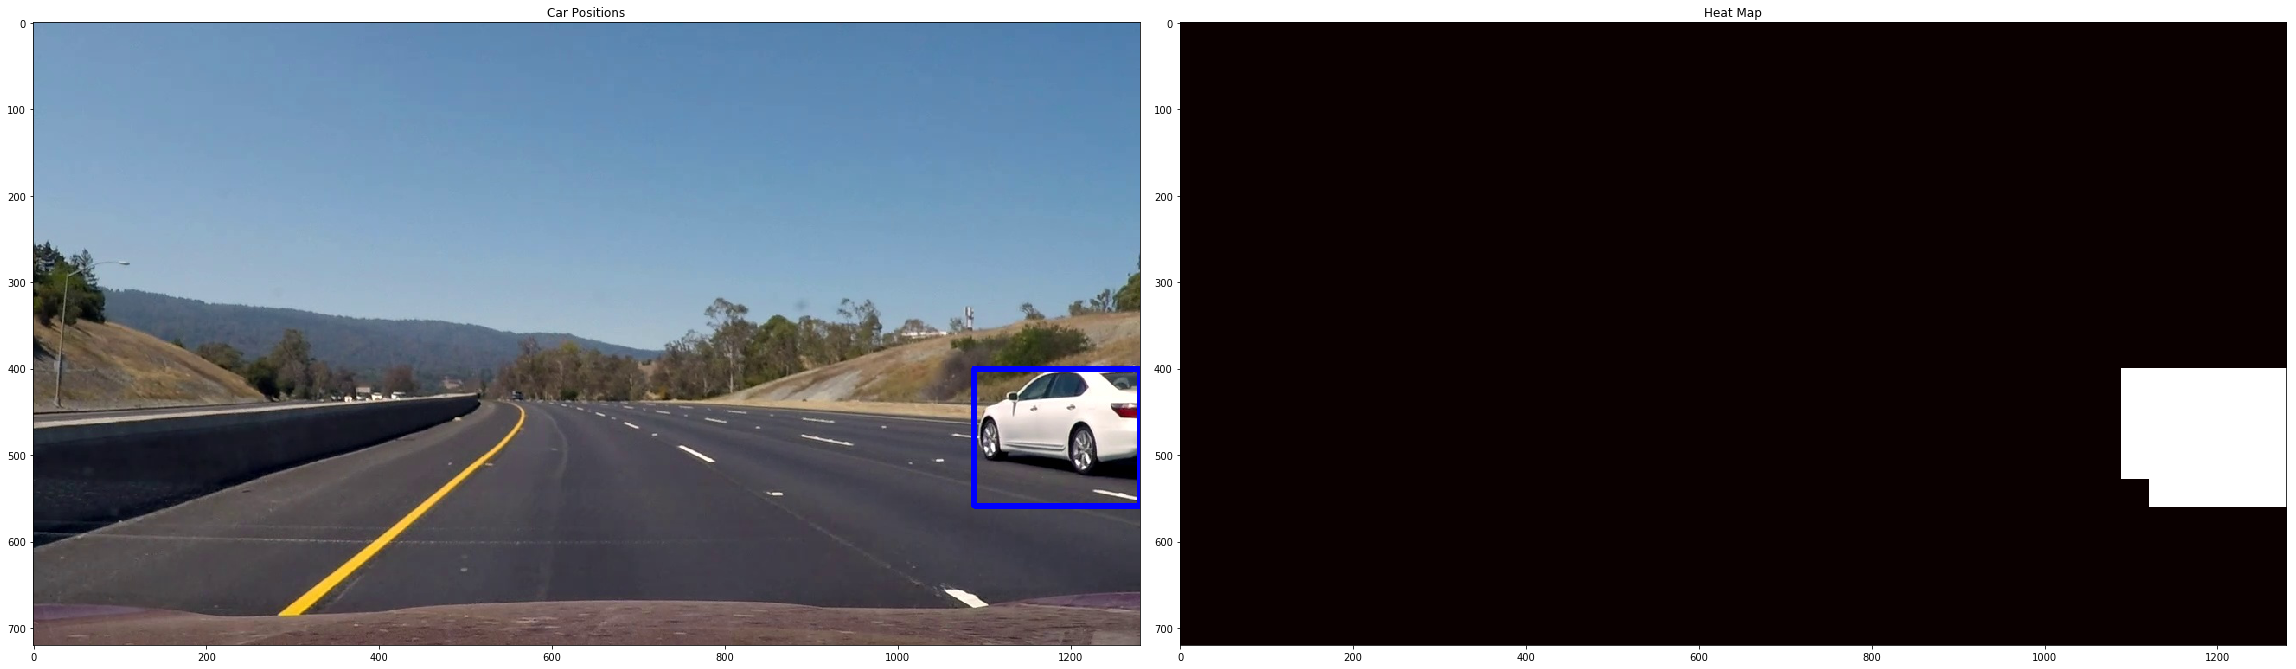

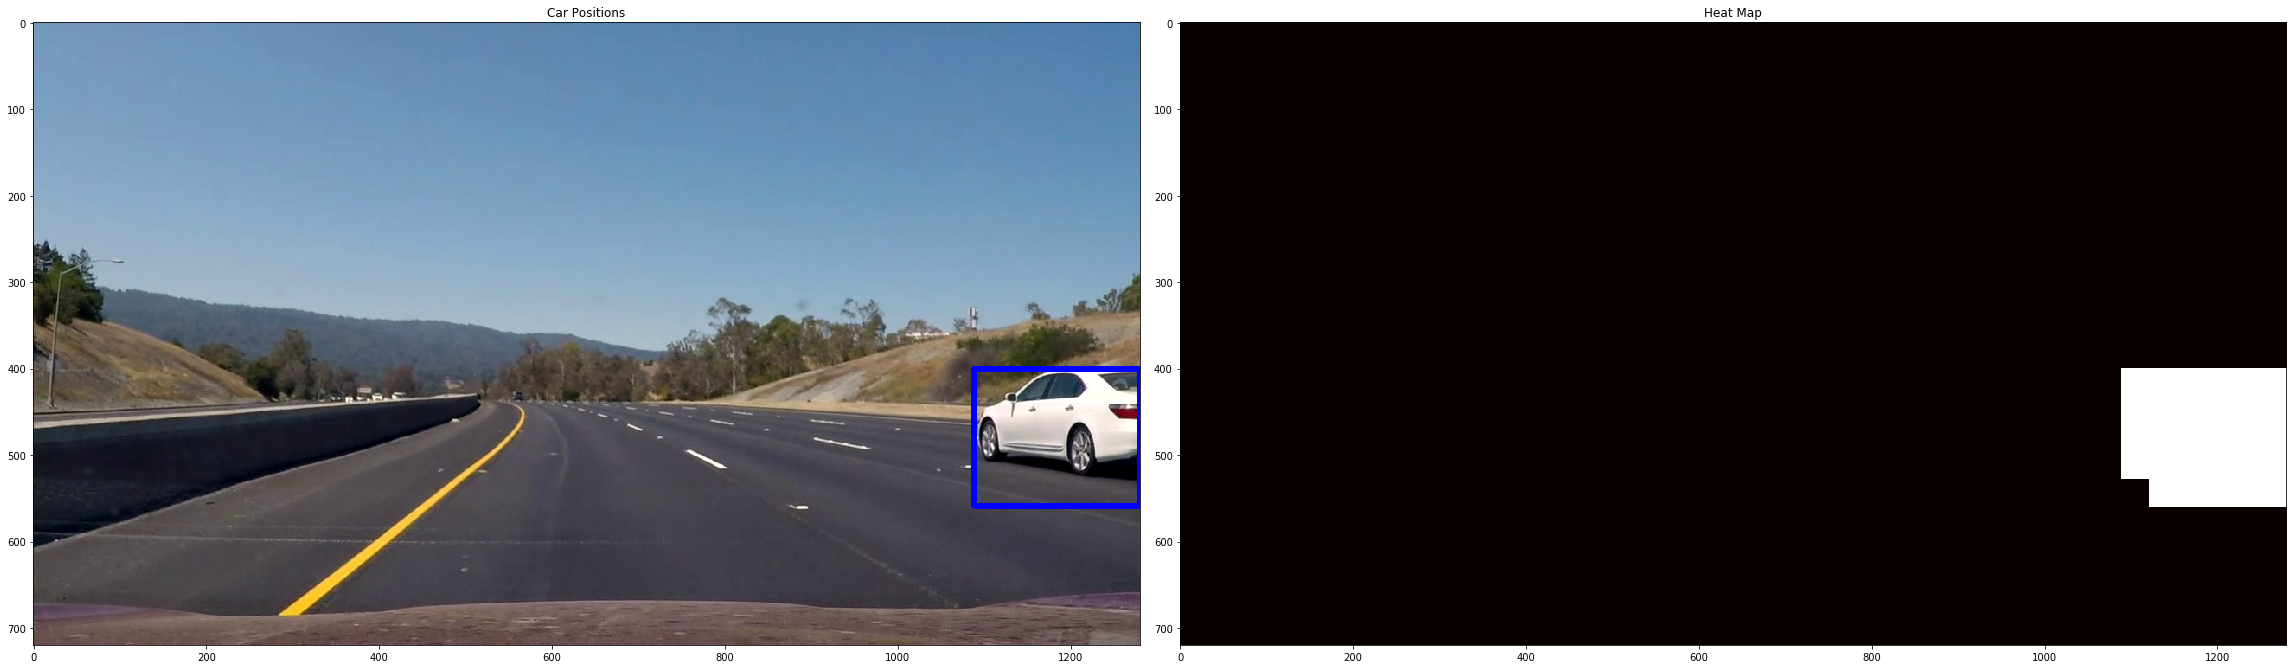

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


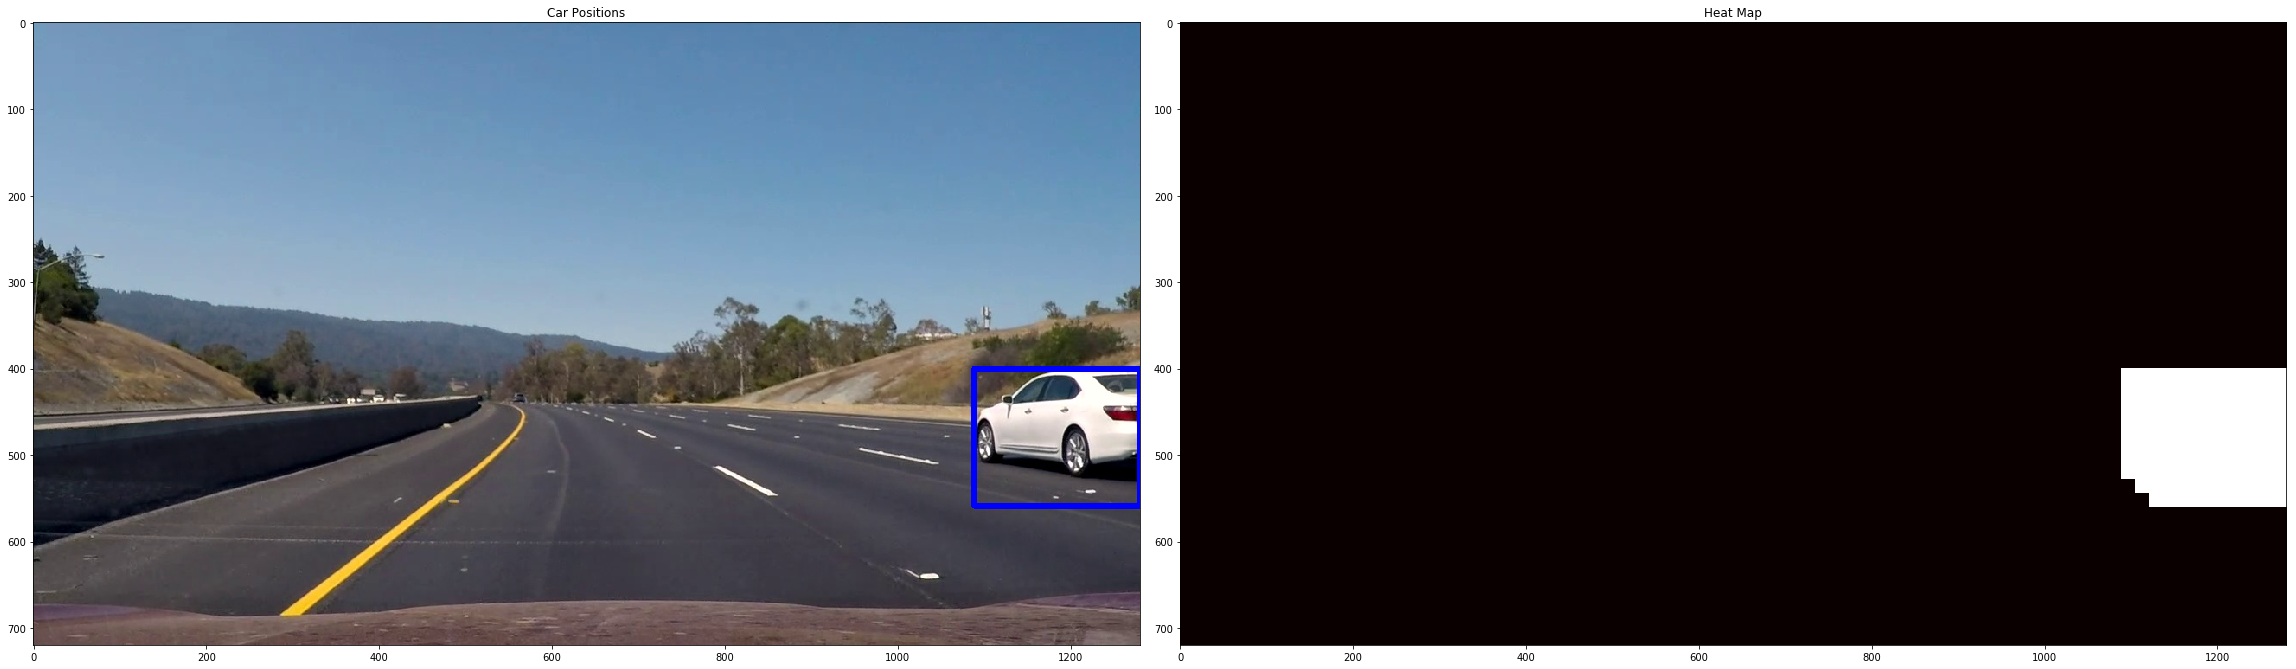

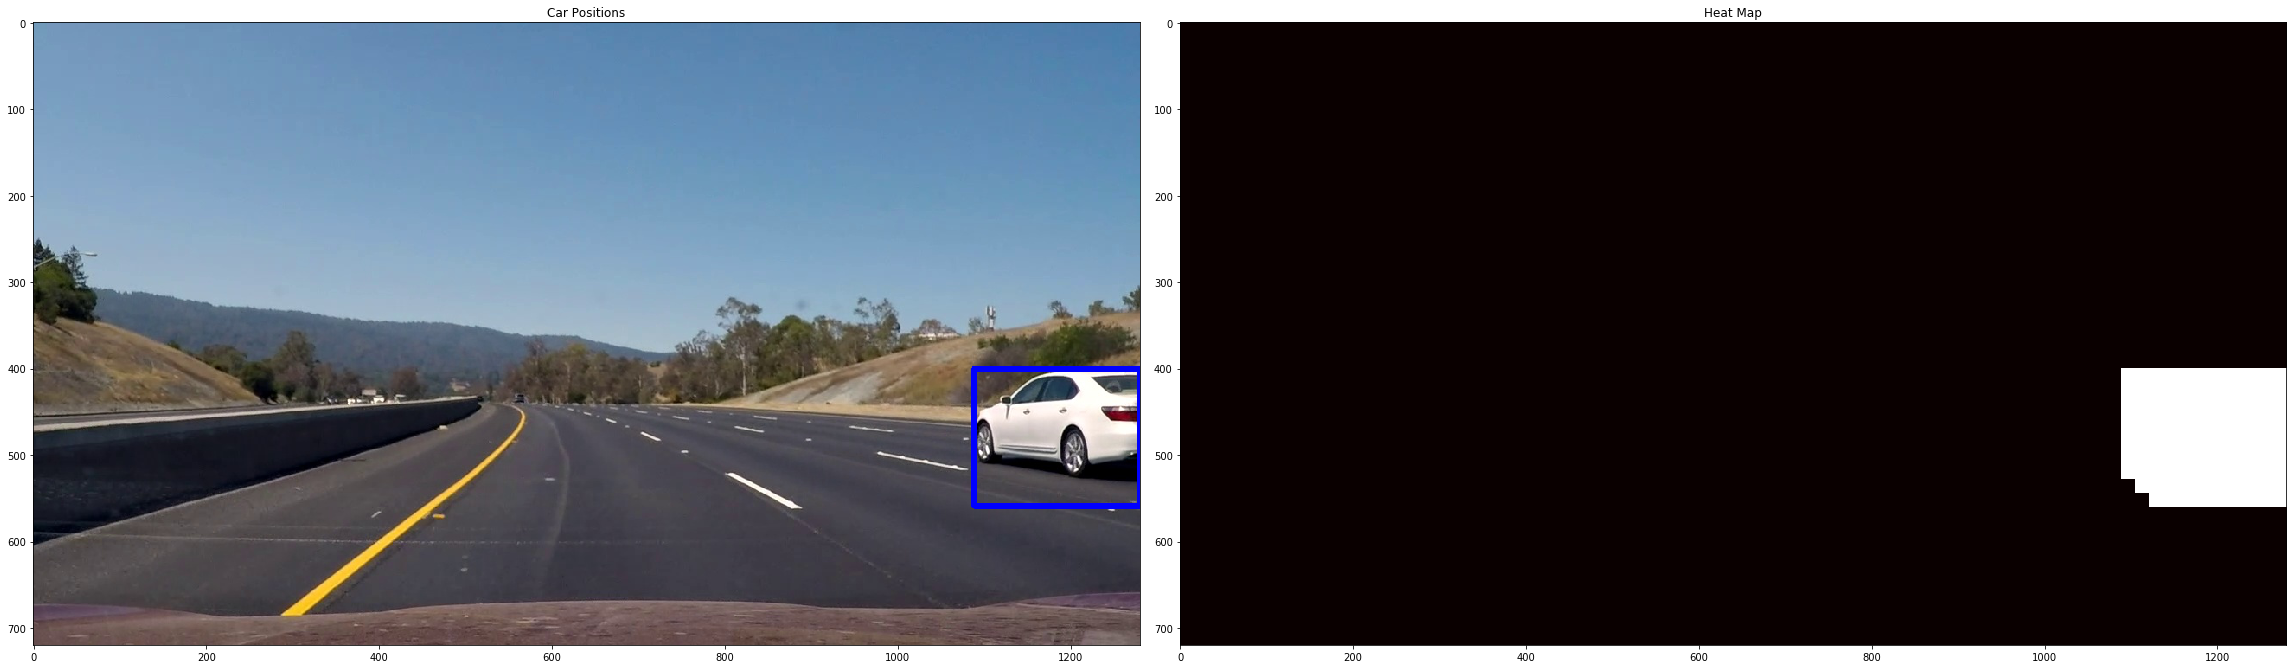

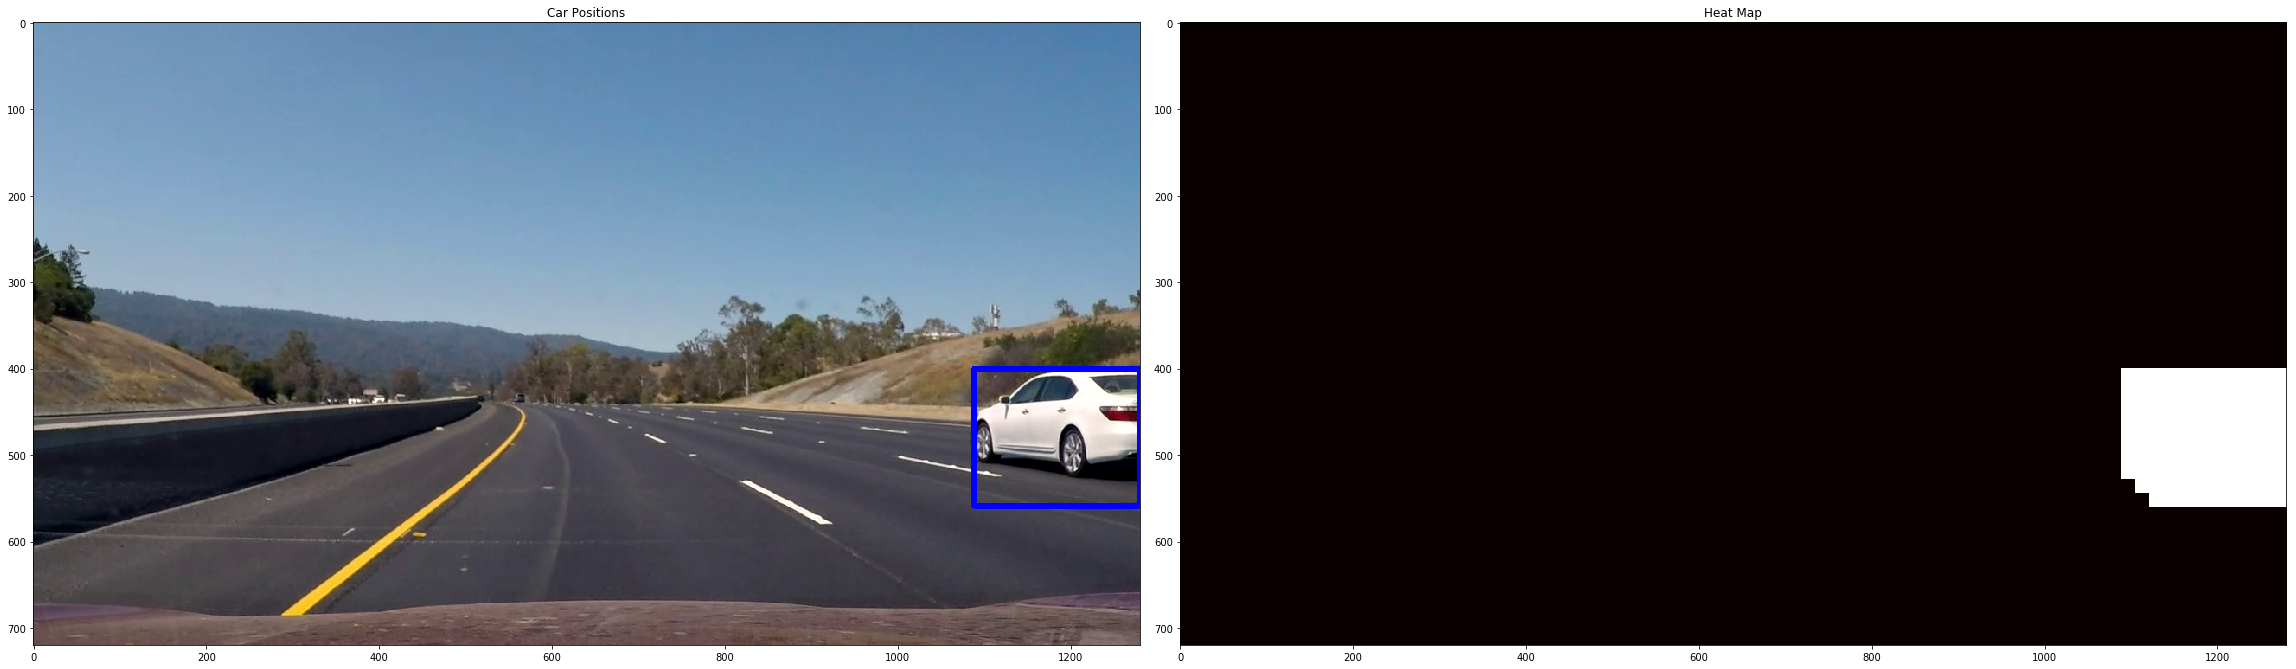

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


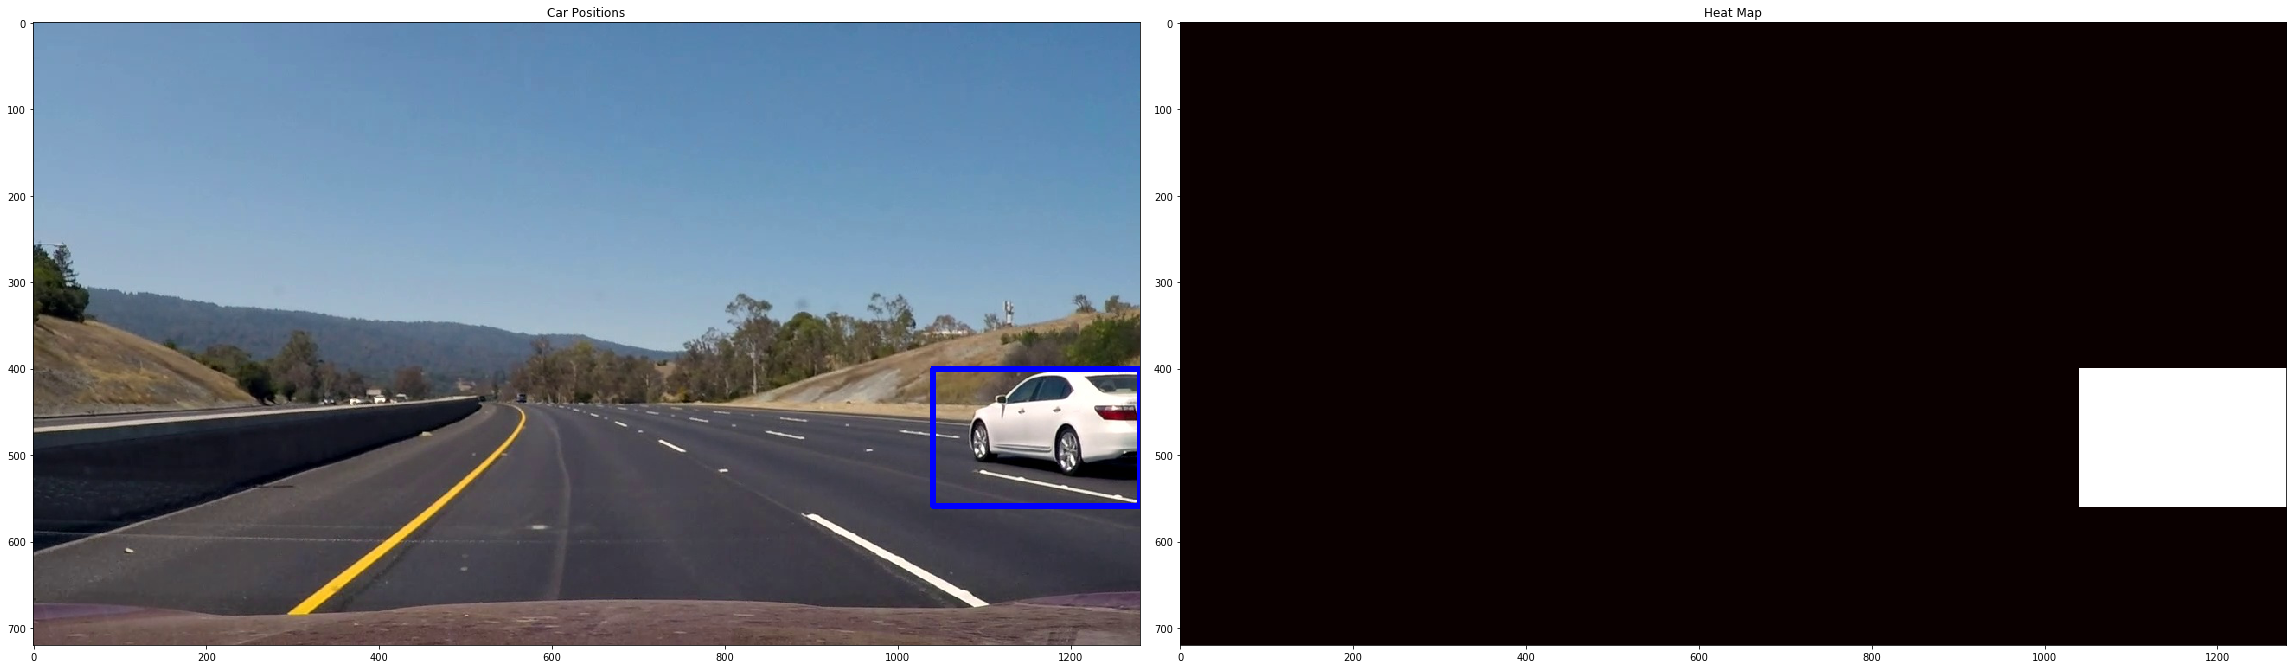

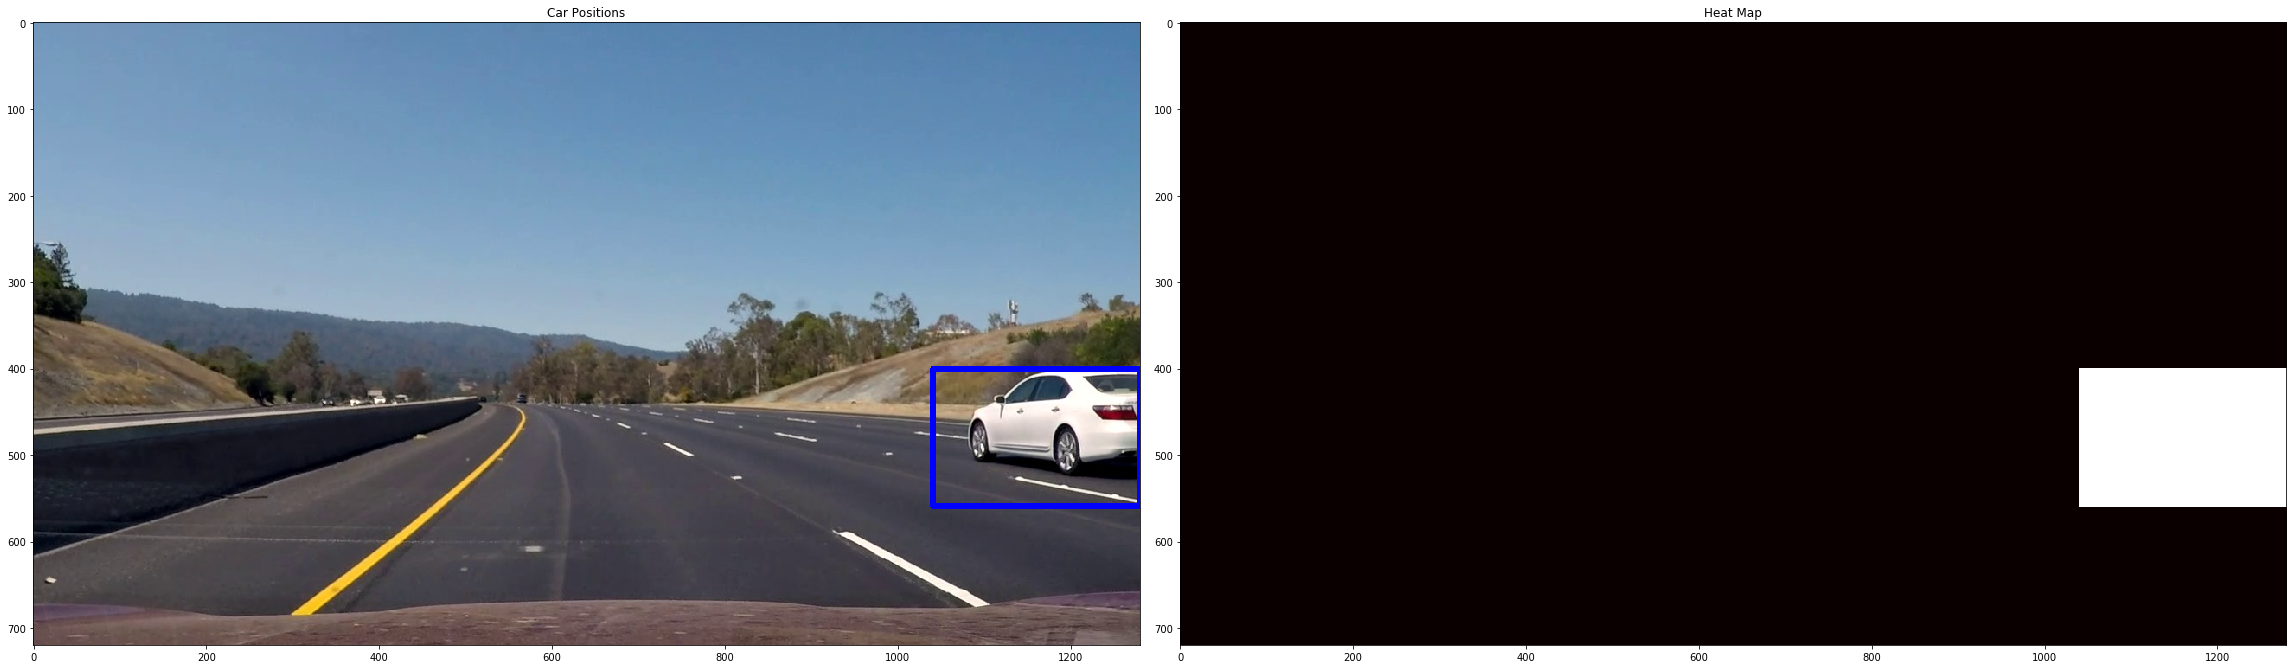

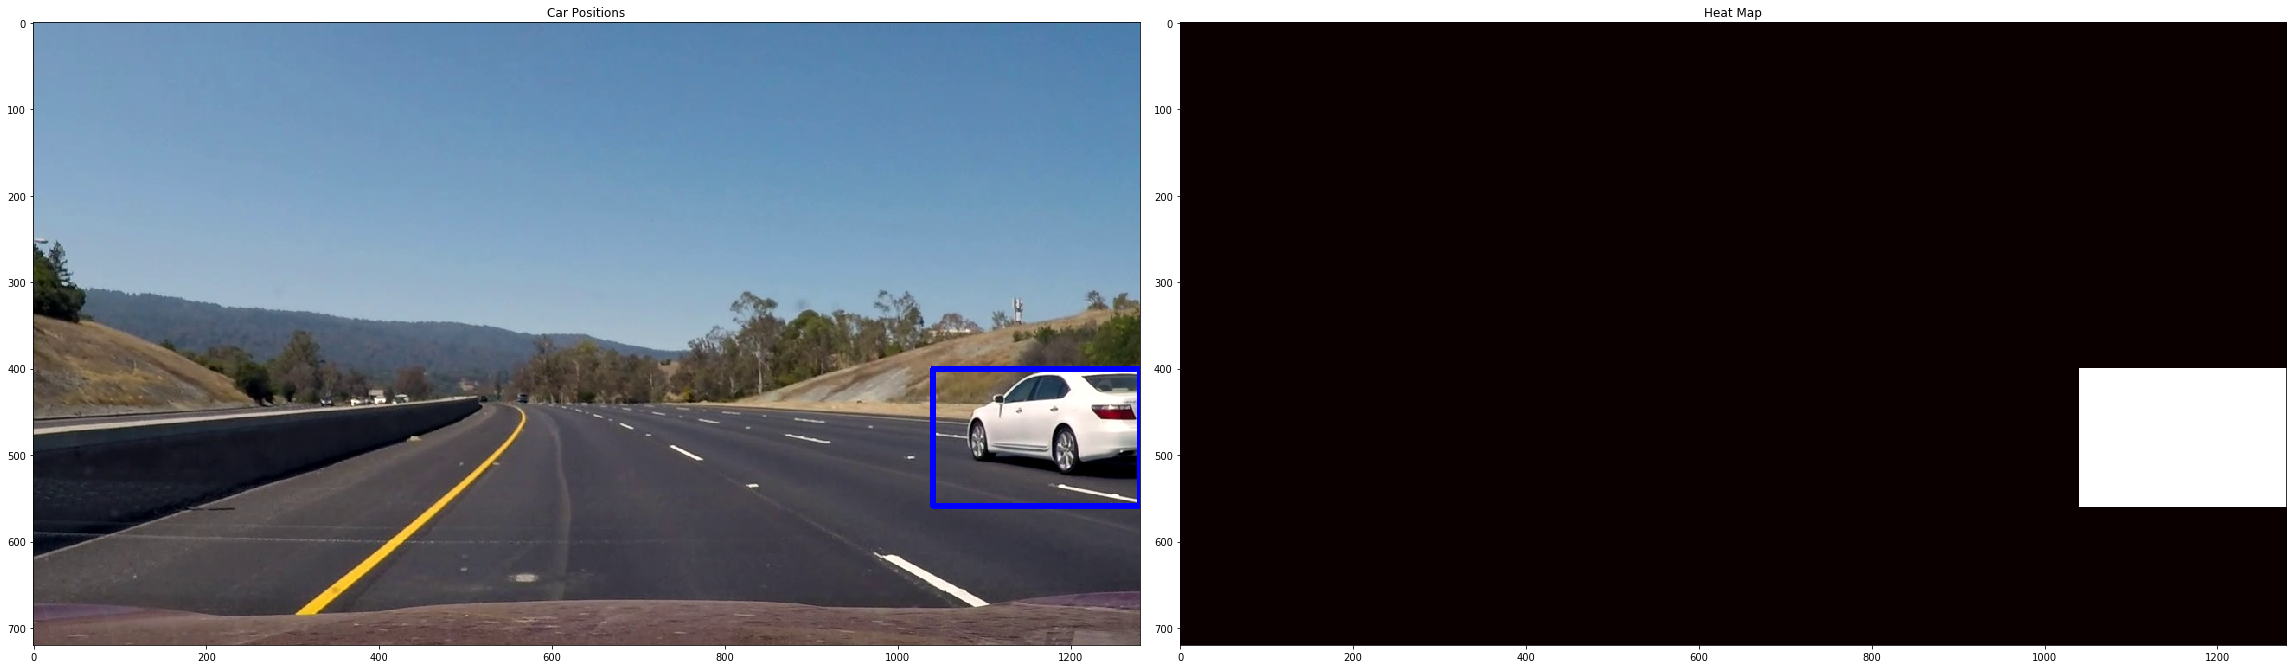

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [71]:
for i in range(len(draw_img_arr)):
    draw_img = draw_img_arr[i]
    heat_map = heat_map_arr[i]
    
    plt.figure(figsize=(32, 32))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heat_map, cmap='hot')
    plt.title('Heat Map')
    plt.tight_layout()
    plt.show()